In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import time
import joblib
import librosa
import numpy as np

In [ ]:
def noise(data,noise_rate=0.015):
    noise_amp = noise_rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [ ]:
# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)
#RMS Energy
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)
#MFCC
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

In [ ]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        rmse(data, frame_length, hop_length),
                        mfcc(data, sr, frame_length, hop_length)
                        ))
    return result
    

In [ ]:
def get_features(path):
    #duration, offset 
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    res1 = extract_features(data,sample_rate)
    result = np.array(res1)
    
    noise_data = noise(data)
    res2 = extract_features(noise_data,sample_rate)
    result = np.vstack((result, res2)) 
    
    data_pitch = pitch(data, sample_rate)
    res3 = extract_features(data_pitch,sample_rate)
    result = np.vstack((result, res3)) 
    
    data_noise_pitch = noise(data_pitch)
    res4 = extract_features(data_noise_pitch,sample_rate)
    result = np.vstack((result, res4)) 
    
    return result

In [ ]:
"""
This files creates the X and y features in joblib to be used by the predictive models.
"""
SAVE_DIR_PATH = "/content/drive/MyDrive/SET_project_1/SER/Model2_using_multiple_dataset"
TRAINING_FILES_PATH = "/content/drive/MyDrive/SET_project_1/SER/data/RAV_TESS"

class CreateFeatures:

    @staticmethod
    def features_creator(path, save_dir) -> str:
        lst = []
        X = []
        y = []
        start_time = time.time()

        for subdir, dirs, files in os.walk(path):
            for file in files:
                try:
                    file_path = os.path.join(subdir, file)
                    print(file_path)
                    feature = get_features(file_path)
                    file = int(file[7:8]) - 1
                    for i in feature:
                      X.append(i)
                      y.append(file)

                except ValueError as err:
                    print(err)
                    continue

        print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

        x_name, y_name = 'Maxx.joblib', 'Maxy.joblib'

        joblib.dump(X, os.path.join(save_dir, x_name))
        joblib.dump(y, os.path.join(save_dir, y_name))

        return X, y


if __name__ == '__main__':
    print('Routine started')
    features, labels = CreateFeatures.features_creator(path=TRAINING_FILES_PATH, save_dir=SAVE_DIR_PATH)
    print('Routine completed.')

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/SET_project_1/SER/data/RAV_TESS/Actor_29/30-71-05-72-16-54-75.wav
/content/drive/MyDrive/SET_project_1/SER/data/RAV_TESS/Actor_29/52-29-04-94-44-85-81.wav
/content/drive/MyDrive/SET_project_1/SER/data/RAV_TESS/Actor_29/33-23-04-12-32-77-76.wav
/content/drive/MyDrive/SET_project_1/SER/data/RAV_TESS/Actor_29/77-89-05-91-94-39-14.wav
/content/drive/MyDrive/SET_project_1/SER/data/RAV_TESS/Actor_29/18-25-04-26-62-14-91.wav
/content/drive/MyDrive/SET_project_1/SER/data/RAV_TESS/Actor_29/27-52-05-12-23-34-85.wav
/content/drive/MyDrive/SET_project_1/SER/data/RAV_TESS/Actor_29/56-13-01-68-38-97-39.wav
/content/drive/MyDrive/SET_project_1/SER/data/RAV_TESS/Actor_29/32-10-06-77-53-34-18.wav
/content/drive/MyDrive/SET_project_1/SER/data/RAV_TESS/Actor_29/89-51-03-30-54-16-14.wav
/content/drive/MyDrive/SET_project_1/SER/data/RAV_TESS/Actor_29/66-98-07-15-85-16-17.wav
/content/drive/MyDrive/SET_project_1/SER/data/RAV_TESS/Acto

In [ ]:
import joblib
X = joblib.load('/content/drive/MyDrive/SET_project_1/SER/Model2_using_multiple_dataset/Maxx.joblib')
Y = joblib.load('/content/drive/MyDrive/SET_project_1/SER/Model2_using_multiple_dataset/Maxy.joblib')

In [ ]:
import pandas as pd
Features = pd.DataFrame(X)
Features.to_csv('features.csv', index=False)
Features.head(20)

,0,1,2,3,4,5,6,7,8,9,...,2366,2367,2368,2369,2370,2371,2372,2373,2374,2375
0,0.000000,0.000000,0.143555,0.247070,0.397461,0.551270,0.490234,0.479004,0.464355,0.478516,...,-1.552493,-0.810598,0.000175,0.404702,0.198592,-0.449355,-1.152433,-1.605650,-1.796601,-1.965609
1,0.229004,0.354492,0.491211,0.499023,0.507324,0.495117,0.479492,0.481934,0.487305,0.497559,...,3.144722,0.644179,0.297512,5.304713,1.496739,-1.628249,4.616487,1.314994,-4.072305,4.302062
2,0.233887,0.341797,0.432129,0.406738,0.311523,0.229980,0.164551,0.115234,0.161133,0.217773,...,-0.998033,-1.028904,-1.144142,-1.431749,-1.902921,-2.496789,-3.103539,-3.598027,-3.873901,-3.869988
3,0.256348,0.381348,0.511230,0.508789,0.499023,0.492676,0.479004,0.466797,0.466797,0.474609,...,-0.875120,-3.738862,0.611715,1.696854,3.458463,3.975656,-1.523594,-2.908699,0.423874,-1.611923
4,0.130371,0.192871,0.260742,0.271973,0.271973,0.280762,0.277832,0.274414,0.271973,0.287109,...,6.031299,1.501364,-3.660282,-8.585302,-3.558325,5.999912,14.882662,7.321812,-7.854089,-4.723037
5,0.205566,0.303711,0.408203,0.407715,0.406738,0.416504,0.411621,0.418945,0.421387,0.428711,...,7.213849,1.489723,-2.082368,-3.039418,-6.376097,2.036631,10.542925,7.314648,-2.441810,-1.203749
6,0.129883,0.191895,0.258301,0.265137,0.270996,0.291992,0.298828,0.295410,0.287598,0.280273,...,12.244992,4.764216,1.121063,-1.158262,5.775679,9.956926,7.663442,-4.804492,-13.198441,-2.197388
7,0.183594,0.282715,0.385742,0.412598,0.422852,0.434570,0.443848,0.437012,0.457520,0.464844,...,8.957797,4.226858,-0.317774,4.130048,4.571097,10.412321,7.098179,-4.711558,-9.454498,-1.614422
8,0.011719,0.024414,0.033203,0.046875,0.156250,0.346680,0.541992,0.735840,0.817383,0.828613,...,1.957587,0.961799,0.670509,0.949075,0.915747,-0.299053,-2.732591,-5.298576,-6.780804,-7.182125
9,0.248047,0.371094,0.495605,0.489258,0.500000,0.503418,0.500977,0.500000,0.486328,0.491211,...,-6.476853,-8.040276,-7.198180,-3.969992,-2.069785,0.216178,1.630214,-0.768921,-3.580100,0.963221


In [ ]:
Features = pd.read_csv('features.csv')
Features.shape

(53160, 2376)

In [ ]:
count = 0
for i in X:
  if i.shape != (2376,):
   count += 1
print(f"Total dimention error {count} out of 53160")

Total dimention error 40516 out of 53160


In [ ]:
Features = Features.fillna(0)
Features.isna().any()
Features.shape

(53160, 2376)

In [ ]:
filled_X = Features.to_numpy()

In [ ]:
count = 0
for i in filled_X:
  if i.shape != (2376,):
   count += 1
print(f"Total dimention error {count} out of 53160")

Total dimention error 0 out of 53160


In [ ]:
Y = np.array(Y)
filled_X.shape, Y.shape

((53160, 2376), (53160,))

In [ ]:
x_name, y_name = 'final_x.joblib', 'final_y.joblib'

joblib.dump(filled_X, os.path.join(SAVE_DIR_PATH, x_name))
joblib.dump(Y, os.path.join(SAVE_DIR_PATH, y_name))

['/content/drive/MyDrive/SET_project_1/SER/Model2_using_multiple_dataset/final_y.joblib']

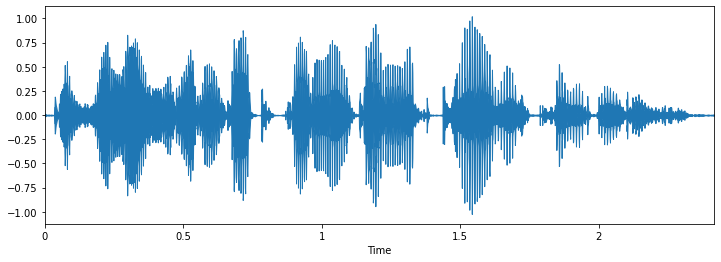

In [ ]:
import librosa
from librosa import display
import matplotlib.pyplot as plt

data, sampling_rate = librosa.load('/content/drive/MyDrive/SET_project_1/SER/data/RAV_TESS/Actor_28/10-11-01-74-43-65-16.wav')
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)